In [ ]:
# MIT License
# Copyright (c) 2025 Xiaotian Han
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files...

In [ ]:
# Success Odds Analysis

In [34]:
import pandas as pd
import numpy as np

# ------------- USER CONFIG ----------------
FILE_PATH       = "Reversal.xlsx"
TICKERS         = ["SMCI"]                  # Tickers to run
DROP_THR        = 0.04                      # ≥ 4 % intraday drop triggers a signal
RECOVER_TARGET  = 0.8                      # ≥ 75 % recovery judged “success”
LOOKAHEAD       = [1, 2, 3, 4,5]           # T+N trading-day windows
# ------------------------------------------

# -------- load every requested sheet into a dict ----------
data: dict[str, pd.DataFrame] = {}
for tic in TICKERS:
    df = pd.read_excel(FILE_PATH, sheet_name=tic)
    df.columns = (df.columns
                    .str.replace(r'[\xa0\u3000\t]', ' ', regex=True)
                    .str.strip())
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.sort_values("Date").reset_index(drop=True)
    df["Adj Close"] = pd.to_numeric(df["Adj Close"], errors="coerce")

    # previous close (after sorting) — fill first row
    df["Prev Close"] = df["Adj Close"].shift(1).fillna(df["Adj Close"])
    data[tic] = df

# -------- analysis engine ----------------------------------
def analyze(df: pd.DataFrame, name: str):
    signals = df[df["Max Drop"] >= DROP_THR].copy()
    rows = []

    for idx, row in signals.iterrows():
        prev_close  = row["Prev Close"]
        low_today   = row["Low"]

        # --- fall_amt fixed once per signal day -----------------
        fall_amt = row["Max Drop"] * prev_close          # uses Max Drop % column
        # fall_amt = prev_close - low_today              # alternate formula
        if fall_amt <= 0 or np.isnan(fall_amt):
            continue
        # --------------------------------------------------------

        for N in LOOKAHEAD:
            if idx + N >= len(df):
                break
            high_n = df.loc[idx+1: idx+N, "High"].max()
            recover_ratio = (high_n - low_today) / fall_amt
            rows.append({
                "Signal Date":       row["Date"].date(),
                "Window N":          N,
                "Max Drop %":        round(row["Max Drop"] * 100, 2),
                "Recover %":         round(recover_ratio * 100, 2),
                "Success?":          recover_ratio >= RECOVER_TARGET,
            })

    result = pd.DataFrame(rows)
    success_rate = (
        result.groupby("Signal Date")["Success?"].any().mean() * 100
        if not result.empty else 0
    )

    print(f"\n===== {name} results =====")
    print(result.head())
    print(f"Signal days: {result['Signal Date'].nunique()}   "
          f"Success rate: {success_rate:.1f}%")

    # Optional save
    # result.to_excel(f"{name}_rebound_test.xlsx", index=False)

# -------- run for each ticker ---------------------------------
for tic in TICKERS:
    analyze(data[tic], tic)



===== SMCI results =====
  Signal Date  Window N  Max Drop %  Recover %  Success?
0  2024-06-26         1        4.13     246.29      True
1  2024-06-26         2        4.13     266.99      True
2  2024-06-26         3        4.13     266.99      True
3  2024-06-26         4        4.13     266.99      True
4  2024-06-26         5        4.13     266.99      True
Signal days: 95   Success rate: 74.7%


In [ ]:
# Profitability CI

In [10]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import yfinance as yf

# ========= USER INPUTS (per run) =========
TICKERS_TO_RUN   = TICKERS  # any subset of data.keys()
CURRENT_SPOT     = yf.Ticker(TICKERS_TO_RUN[0]).info["regularMarketPrice"]             
STRIKE           = 50                 # strike
CALL_COST        = 5                # cost per share
IMPLIED_VOL      = 0.75              # fallback IV
USE_ROLLING_SIGMA= True                # True -> override IV with rolling σ
ROLL_WIN         = 20                  # rolling window if above is True

CURRENT_DATE     = "2025-07-21"        # today's date
EXPIRY_DATE      = "2025-08-22"        # expiry date

LOOKAHEAD        = LOOKAHEAD           # T + N (trading days)
CONF_LEVEL       = 0.9                 # 99 % CI
DROP_THR         = DROP_THR            # draw-down trigger
RISK_FREE        = 0.035               # risk-free rate
BOOT_SIMS        = 30_000              # bootstrap draws
# =========================================

# ⏳ Compute days to expiration
CURRENT_DATE = datetime.strptime(CURRENT_DATE, "%Y-%m-%d")
EXPIRY_DATE  = datetime.strptime(EXPIRY_DATE, "%Y-%m-%d")
DAYS_TO_EXP = (EXPIRY_DATE - CURRENT_DATE).days

# ---------- Black-Scholes ----------
def bs_call(spot, strike, t, r, sigma):
    if t <= 0:
        return np.maximum(spot - strike, 0.0)
    d1 = (np.log(spot/strike) + (r + 0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    return spot*norm.cdf(d1) - strike*np.exp(-r*t)*norm.cdf(d2)

# ---------- CI engine ----------
def option_return_ci(df, lookahead, spot, strike, cost, iv,
                     tau_days, drop_thr=0.04, conf=0.95,
                     r=0.05, n_boot=30_000):

    # conditional log-return pool
    signals = df[df["Max Drop"] >= drop_thr]
    logret  = {n: [] for n in lookahead}
    for idx, row in signals.iterrows():
        s0 = row["Adj Close"]
        for n in lookahead:
            if idx + n >= len(df): break
            sn = df.loc[idx+n, "Adj Close"]
            logret[n].append(np.log(sn / s0))

    a_lo, a_hi = (1-conf)/2, 1-(1-conf)/2
    rows = []

    for n in lookahead:
        sample = np.asarray(logret[n])
        if sample.size == 0: continue
        draws  = np.random.choice(sample, size=n_boot, replace=True)
        tau    = max((tau_days - n)/365, 0)
        spots  = spot * np.exp(draws)
        calls  = bs_call(spots, strike, tau, r, iv)
        rets   = (calls - cost) / cost
        rows.append({
            "N": n,
            "mean_%":           round(rets.mean()*100,2),
            f"{int(conf*100)}%_low_%":  round(np.quantile(rets, a_lo)*100,2),
            f"{int(conf*100)}%_high_%": round(np.quantile(rets, a_hi)*100,2)
        })
    return pd.DataFrame(rows)

# ---------- run for each ticker ----------
for tic in TICKERS_TO_RUN:
    if tic not in data:
        print(f"{tic} not loaded in Part 1; skip.")
        continue

    df = data[tic]

    # optional rolling σ override
    iv_use = IMPLIED_VOL
    if USE_ROLLING_SIGMA:
        log_r = np.log(df["Adj Close"]/df["Adj Close"].shift(1)).dropna()
        sigma_d = log_r.rolling(ROLL_WIN).std().iloc[-1]
        iv_use  = sigma_d * np.sqrt(252)
        print(f"{tic}: rolling {ROLL_WIN}-day σ = {iv_use:.2%}")

    ci = option_return_ci(df,
                          lookahead=LOOKAHEAD,
                          spot=CURRENT_SPOT,
                          strike=STRIKE,
                          cost=CALL_COST,
                          iv=iv_use,
                          tau_days=DAYS_TO_EXP,
                          drop_thr=DROP_THR,
                          conf=CONF_LEVEL,
                          r=RISK_FREE,
                          n_boot=BOOT_SIMS)

    print(f"\n===== {tic}  {STRIKE}-strike Call  ({int(CONF_LEVEL*100)}% CI) =====")
    print(ci.to_string(index=False))
    print(f"CURRENT SPOT = {CURRENT_SPOT}, Implied Vol Used = {iv_use:.2f}, DAYS to Expiry = {DAYS_TO_EXP}","Days")

    


SMCI: rolling 20-day σ = 69.09%

===== SMCI  50-strike Call  (90% CI) =====
 N  mean_%  90%_low_%  90%_high_%
 1   13.83     -54.91      106.80
 2   15.41     -77.68      161.97
 3   26.63     -83.54      242.44
 4   32.98     -87.69      351.95
 5   45.15     -91.61      346.42
CURRENT SPOT = 52.03, Implied Vol Used = 0.69, DAYS to Expiry = 32 Days


In [248]:
# GBM CI

In [13]:
import numpy as np
from scipy.stats import norm
import pandas as pd

# ========= USER INPUTS (per run) =========
TICKERS_TO_RUN = TICKERS            # any subset of data.keys()
SPOT_NOW       = CURRENT_SPOT        # current stock price
STRIKE         = STRIKE
CALL_COST      = CALL_COST
DAYS_TO_EXP    = DAYS_TO_EXP                  # calendar days to expiry
LOOKAHEAD      = LOOKAHEAD     # T+N trading days
CONF_LEVEL     = CONF_LEVEL
DRIFT_MODE     = "rf"                # "hist" or "rf"
PATHS          = 50_000
RISK_FREE      = 0.035
# (optional) override volatility instead of hist σ:
SIGMA_OVERRIDE = iv_use                # e.g. 0.60  -> use 60 % annual vol
# =========================================

# ---------- helpers ----------
def bs_call(spot, strike, t, r, sigma):
    if t <= 0:
        return np.maximum(spot - strike, 0.0)
    d1 = (np.log(spot/strike) + (r + 0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    return spot*norm.cdf(d1) - strike*np.exp(-r*t)*norm.cdf(d2)

def gbm_ci(df, spot_now, strike, cost, lookahead,
           days_to_exp, conf=0.95, paths=50_000,
           drift_mode="hist", r=0.05, sigma_override=None):

    # --- daily μ, σ ---
    log_r = np.log(df["Adj Close"]/df["Adj Close"].shift(1)).dropna()
    sigma_d = sigma_override/np.sqrt(252) if sigma_override else log_r.std(ddof=1)
    mu_d    = log_r.mean() if drift_mode=="hist" else r/252
    sigma_a = sigma_d*np.sqrt(252)

    rows, lo = [], (1-conf)/2
    hi = 1 - lo

    for n in lookahead:
        z   = np.random.normal(size=paths)
        lnS = (mu_d - 0.5*sigma_d**2)*n + sigma_d*np.sqrt(n)*z
        spots = spot_now * np.exp(lnS)

        tau   = max((days_to_exp - n)/365, 0)
        calls = bs_call(spots, strike, tau, r, sigma_a)
        ret   = (calls - cost) / cost

        rows.append({
            "N": n,
            "mean_%":          round(ret.mean()*100, 2),
            f"{int(conf*100)}%_low_%":  round(np.quantile(ret, lo)*100, 2),
            f"{int(conf*100)}%_high_%": round(np.quantile(ret, hi)*100, 2),
            "σ_ann_%":         round(sigma_a*100, 2)
        })
    return pd.DataFrame(rows)

# ---------- run for each ticker ----------
for tic in TICKERS_TO_RUN:
    if tic not in data:
        print(f"{tic} not loaded – run Part 1 first.")
        continue

    df = data[tic]
    ci_gbm = gbm_ci(df,
                    spot_now=SPOT_NOW,
                    strike=STRIKE,
                    cost=CALL_COST,
                    lookahead=LOOKAHEAD,
                    days_to_exp=DAYS_TO_EXP,
                    conf=CONF_LEVEL,
                    paths=PATHS,
                    drift_mode=DRIFT_MODE,
                    r=RISK_FREE,
                    sigma_override=SIGMA_OVERRIDE)

    print(f"\n===== {tic} GBM   {STRIKE}-strike Call  ({int(CONF_LEVEL*100)}% CI) =====")
    print(ci_gbm.to_string(index=False))
    print(f"CURRENT SPOT = {CURRENT_SPOT}, Implied Vol Used = {iv_use:.2f}, DAYS to Expiry = {DAYS_TO_EXP}","Days")


===== SMCI GBM   50-strike Call  (90% CI) =====
 N  mean_%  90%_low_%  90%_high_%  σ_ann_%
 1    7.05     -34.97       56.97    69.09
 2    7.78     -49.49       80.90    69.09
 3    8.37     -59.10      102.00    69.09
 4    9.22     -66.30      120.02    69.09
 5    9.49     -72.50      134.67    69.09
CURRENT SPOT = 52.03, Implied Vol Used = 0.69, DAYS to Expiry = 32 Days


In [ ]:
# Rolling Sigma

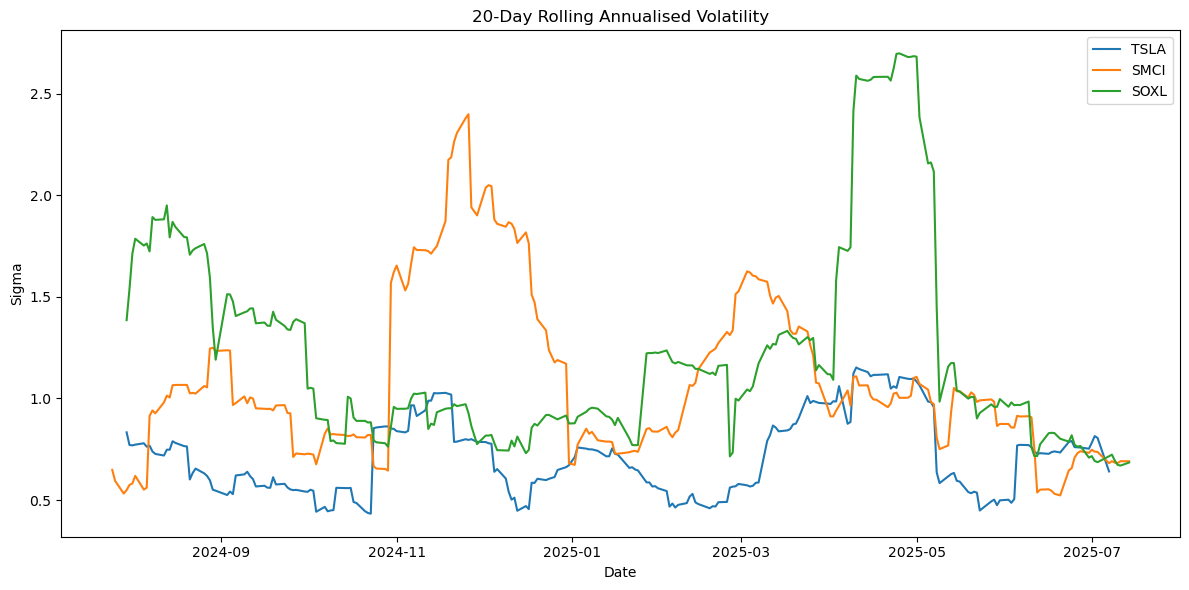

In [33]:
import matplotlib.pyplot as plt

rolling_window = 20

def plot_rolling_sigma(ticker_list, win=rolling_window, ann_factor=252,
                       file_path="Reversal.xlsx"):
    """
    Plot rolling annualised σ for all tickers requested.
    If a ticker is missing from `data`, automatically load the sheet,
    clean it the same way as in Part 1, and store it back into `data`.
    """
    plt.figure(figsize=(12, 6))
    failed = []

    for tic in ticker_list:
        # -------- ensure DataFrame exists ----------
        if tic not in data:
            try:
                df_tmp = pd.read_excel(file_path, sheet_name=tic)
                df_tmp.columns = (df_tmp.columns
                                   .str.replace(r'[\xa0\u3000\t]', ' ', regex=True)
                                   .str.strip())
                df_tmp["Date"] = pd.to_datetime(df_tmp["Date"])
                df_tmp = df_tmp.sort_values("Date").reset_index(drop=True)
                df_tmp["Adj Close"] = pd.to_numeric(df_tmp["Adj Close"], errors="coerce")
                data[tic] = df_tmp
                print(f"Loaded {tic} from sheet.")        # optional feedback
            except Exception as e:
                failed.append(tic)
                print(f"⚠️  {tic} not found ({e}); skipping.")
                continue
        # -------------------------------------------

        df = data[tic]
        log_r = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
        roll_sig = log_r.rolling(win).std() * np.sqrt(ann_factor)
        plt.plot(df["Date"], roll_sig, label=tic)

    if failed:
        print("Could not plot:", ", ".join(failed))

    plt.title(f"{win}-Day Rolling Annualised Volatility")
    plt.xlabel("Date")
    plt.ylabel("Sigma")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_rolling_sigma(["TSLA","SMCI","SOXL"]) # Enter Multiple Tickers here, separated by comma


In [376]:
# Tickers Screening from SP500 & Nasdaq

In [38]:
# === Part 5: US Stock Screener (S&P 500 + NASDAQ-100) ===

import pandas as pd
import numpy as np
import yfinance as yf
from tqdm import tqdm
from datetime import datetime

# === Screener Function ===
def screen_stocks(tickers, max_pe, min_market_cap, min_change_pct,
                  min_dividend_yield, min_volatility, min_volume):
    result = []

    for ticker in tqdm(tickers, desc="Screening"):
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="1mo", interval="1d")

            if len(hist) < 21:
                continue

            hist['LogRet'] = np.log(hist['Close'] / hist['Close'].shift(1))
            trailing_vol = hist['LogRet'].rolling(20).std().iloc[-1] * np.sqrt(252)

            today_close = hist['Close'].iloc[-1]
            prev_close = hist['Close'].iloc[-2]
            pct_change = (today_close - prev_close) / prev_close * 100

            info = stock.info
            market_cap = info.get("marketCap", 0)
            pe_ratio = info.get("trailingPE", np.inf) or np.inf
            dividend_yield = info.get("dividendYield", 0) or 0
            volume = info.get("volume", 0)

            # Apply change direction filter
            if min_change_pct < 0:
                change_condition = pct_change <= min_change_pct
            else:
                change_condition = pct_change >= min_change_pct

            # Apply filter criteria
            if (
                market_cap >= min_market_cap and
                pe_ratio <= max_pe and
                change_condition and
                dividend_yield * 100 >= min_dividend_yield and
                trailing_vol >= min_volatility and
                volume >= min_volume
            ):
                result.append({
                    'Ticker': ticker,
                    'Market Cap': market_cap,
                    'P/E Ratio': round(pe_ratio, 2),
                    'Price': round(today_close, 2),
                    'Change %': round(pct_change, 2),
                    '20D Volatility': round(trailing_vol, 4),
                    'Dividend Yield %': round(dividend_yield * 100, 2),
                    'Volume': volume
                })

        except Exception as e:
            print(f"[{ticker}] Error: {type(e).__name__} – {e}")
            continue

    return pd.DataFrame(result)


# === Load Tickers from Wikipedia ===
def load_us_tickers():
    print("Loading tickers from S&P 500 and NASDAQ-100...")
    try:
        sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        sp500_table = pd.read_html(sp500_url)[0]
        sp500_tickers = sp500_table['Symbol'].tolist()
    except Exception as e:
        print(f"Failed to load S&P 500: {e}")
        sp500_tickers = []

    try:
        nasdaq_url = "https://en.wikipedia.org/wiki/NASDAQ-100"
        nasdaq_table = pd.read_html(nasdaq_url)[4]
        nasdaq_tickers = nasdaq_table['Ticker'].tolist()
    except Exception as e:
        print(f"Failed to load NASDAQ-100: {e}")
        nasdaq_tickers = []

    tickers = sorted(set(sp500_tickers + nasdaq_tickers))
    print(f"Loaded {len(tickers)} tickers.")
    return tickers


# === Main Execution ===
def main():
    # Get user inputs
    max_pe = float(input("Maximum P/E Ratio: "))
    min_market_cap = float(input("Minimum Market Cap (e.g. 1e10 for $10B): "))
    min_change_pct = float(input("Minimum Daily Change % (use negative for drop): "))
    min_dividend_yield = float(input("Minimum Dividend Yield (%): "))
    min_volatility = float(input("Minimum 20D Volatility: "))
    min_volume = float(input("Minimum Daily Volume: "))

    # Load tickers and run screener
    tickers = load_us_tickers()
    tickers = [t for t in tickers if t not in {"BRK.B", "BF.B"}]  # skip problematic tickers BF.B and BRK.B
    df = screen_stocks(
        tickers=tickers,
        max_pe=max_pe,
        min_market_cap=min_market_cap,
        min_change_pct=min_change_pct,
        min_dividend_yield=min_dividend_yield,
        min_volatility=min_volatility,
        min_volume=min_volume
    )
    run_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"\n Screener Run Time: {run_time}")

    # Show and save
    if df.empty:
        print("No stocks matched your criteria.")
    else:
        df = df.sort_values(by='Change %', ascending=False)
        print("\nScreened Results:")
        print(df)
        save = input("\nSave results to CSV? (y/n): ").strip().lower()
        if save == 'y':
            df.to_csv("filtered_stocks.csv", index=False)
            print("Saved to 'filtered_stocks.csv'.")


if __name__ == "__main__":
    main()


Maximum P/E Ratio:  45
Minimum Market Cap (e.g. 1e10 for $10B):  15e10
Minimum Daily Change % (use negative for drop):  -4
Minimum Dividend Yield (%):  0
Minimum 20D Volatility:  0.5
Minimum Daily Volume:  2e7


Loading tickers from S&P 500 and NASDAQ-100...
Loaded 516 tickers.


Screening: 100%|██████████████████████████████| 514/514 [03:42<00:00,  2.31it/s]



 Screener Run Time: 2025-07-23 14:34:22

Screened Results:
  Ticker    Market Cap  P/E Ratio   Price  Change %  20D Volatility  \
0    TXN  169166569472       35.2  186.21    -13.36          0.5373   

   Dividend Yield %    Volume  
0             253.0  22769163  



Save results to CSV? (y/n):  n
